In [1]:
import pandas as pd
import numpy as np
import glob
import geopandas as gpd
import datetime

### Identifying administrative boundaries

In [2]:
india_district = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\keys_identifiers\districts_2.csv')
district = india_district.loc[india_district['StateCode']==2]
district = district.rename(columns={'DistrictId':'district_id','DistrictName':'district_name'})

india_subdistrict = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\keys_identifiers\st_sub-district.csv')
him_dist = district['district_id'].unique().tolist()
subdistrict = india_subdistrict.loc[india_subdistrict['districtid'].isin(him_dist)]
subdistrict = subdistrict.loc[subdistrict['status'] == 'Active']

divisions = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\keys_identifiers\st_division.csv')
circles = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\keys_identifiers\circles.csv')
blocks = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\keys_identifiers\st_block.csv')
ulb = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\keys_identifiers\st_ulb.csv')
hp_villages = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Maps\HP_VILLAGES.csv')
hp_gdf = gpd.read_file(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Maps\HP_IDS-DRR_shapefiles\hp_tehsil_final.geojson')
villages = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Maps\HP_VILLAGES.csv')

In [3]:
subdistrict = subdistrict.rename(columns={'districtid':'district_id'})
dist_subdist_map = pd.merge(
    district[['district_id',  'district_name'#,'DistrictCode', 'Census_2001_Code','Census_2011_Code'
              ]], 
       subdistrict[['sub_district_id','sub_district_name', 'sub_district_name_hindi', 'district_id']],
    how='right',
    on='district_id',
    suffixes=('_district', '_subdistrict')
)
dist_subdist_map

,district_id,district_name,sub_district_id,sub_district_name,sub_district_name_hindi
0,16,CHAMBA,83,Bharmaur,पांगी
1,16,CHAMBA,84,Chamba,चौराह
2,16,CHAMBA,85,Chowari,सलूणी
3,16,CHAMBA,86,Churah,भलाई
4,16,CHAMBA,87,Dalhousie,डलहौज़ी
...,...,...,...,...,...
79,22,MANDI,8664,Chahuntra,NaN
80,24,SIRMAUR,8665,Kafota,NaN
81,23,SHIMLA,8668,Kupvi,Kupvi
82,23,SHIMLA,8669,Jubbal,Jubbal


In [4]:
# geocoding_function

import os
import re
import pandas as pd
from difflib import SequenceMatcher
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")


def clean_text(text):
    """Utility to clean and lower-case a string."""
    if not text:
        return ""
    return re.sub(r'[^a-zA-Z0-9\s]', ' ', str(text)).lower().strip()


def build_mappings(villages_df):
    """
    Build useful mappings from the villages dataframe.
      - district_candidates: unique cleaned district names from 'dtname'
      - village_to_district: maps cleaned village name (from VILNAM_SOI) to dtname
      - subdistrict_to_district: maps cleaned subdistrict name (from sdtname) to dtname.
        (If multiple rows exist, the first encountered is used.)
    """
    # Candidate districts
    district_candidates = villages_df['dtname'].dropna().unique().tolist()
    district_candidates = [clean_text(d) for d in district_candidates]

    village_to_district = {}
    for idx, row in villages_df.iterrows():
        village = clean_text(row.get('VILNAM_SOI', ''))
        district = row.get('dtname', '').strip()
        if village and village not in village_to_district:
            village_to_district[village] = district

    subdistrict_to_district = {}
    for idx, row in villages_df.iterrows():
        subdistrict = clean_text(row.get('sdtname', ''))
        district = row.get('dtname', '').strip()
        if subdistrict and subdistrict not in subdistrict_to_district:
            subdistrict_to_district[subdistrict] = district

    return district_candidates, village_to_district, subdistrict_to_district


def fuzzy_match(text, candidates):
    """
    Returns a sorted list of (candidate, score) tuples for the input text compared against
    a list of candidate strings using SequenceMatcher.
    """
    scores = []
    for candidate in candidates:
        score = SequenceMatcher(None, text, candidate).ratio()
        scores.append((candidate, score))
    return sorted(scores, key=lambda x: x[1], reverse=True)


def geotag_district(ungeo_df, villages_df, threshold=0.80, conflict_margin=0.05):
    """
    For each record in the ungeocoded dataset, assign a district.
    
    Process:
      1. Attempt direct matching using the 'district_name' column against candidate districts (dtname).
      2. If the direct match is missing or its score is below the threshold, build a fallback string
         from ['circle_name', 'block_name', 'division_name', 'location'] and try:
           a. Fuzzy match against candidate villages (VILNAM_SOI).
           b. If that fails, fuzzy match against candidate subdistricts (sdtname).
         In either fallback, return the corresponding district (dtname) using mappings.
         
      If the top two candidates are nearly equal (within conflict_margin), record an alternative.
    
    The function adds two new columns to ungeo_df:
        - 'district_best'
        - 'district_alternative'
    """
    # Build mappings and candidate lists
    district_candidates, village_to_district, subdistrict_to_district = build_mappings(villages_df)
    candidate_villages = list(village_to_district.keys())
    candidate_subdistricts = list(subdistrict_to_district.keys())

    district_best_list = []
    district_alt_list = []

    for idx, row in tqdm(ungeo_df.iterrows(), total=ungeo_df.shape[0], desc="Geotagging District"):
        # Step 1: Direct District Matching
        district_input = clean_text(row.get('district_name', ''))
        best_match = ""
        alt_match = ""
        best_score = 0.0

        if district_input:
            matches = fuzzy_match(district_input, district_candidates)
            if matches:
                best_candidate, best_score = matches[0]
                if best_score >= threshold:
                    best_match = best_candidate  # already cleaned
                    if len(matches) > 1:
                        second_candidate, second_score = matches[1]
                        if second_score >= threshold * 0.9 and (best_score - second_score) < conflict_margin:
                            alt_match = second_candidate

        # Step 2: Fallback Matching if needed
        if not best_match or best_score < threshold:
            fallback_parts = []
            for col in ['circle_name', 'block_name', 'division_name', 'location']:
                val = row.get(col, '')
                if pd.notnull(val) and str(val).strip():
                    fallback_parts.append(str(val))
            fallback_text = clean_text(" ".join(fallback_parts))

            fallback_best = ""
            fallback_alt = ""
            fallback_score = 0.0
            if fallback_text:
                village_matches = fuzzy_match(fallback_text, candidate_villages)
                if village_matches:
                    best_village, fallback_score = village_matches[0]
                    if fallback_score >= threshold:
                        fallback_best = village_to_district.get(best_village, "")
                        if len(village_matches) > 1:
                            second_village, second_score = village_matches[1]
                            if second_score >= threshold * 0.9 and (fallback_score - second_score) < conflict_margin:
                                fallback_alt = village_to_district.get(second_village, "")
                # If no good village match, try subdistrict names.
                if not fallback_best and fallback_text:
                    subd_matches = fuzzy_match(fallback_text, candidate_subdistricts)
                    if subd_matches:
                        best_subd, fallback_score = subd_matches[0]
                        if fallback_score >= threshold:
                            fallback_best = subdistrict_to_district.get(best_subd, "")
                            if len(subd_matches) > 1:
                                second_subd, second_score = subd_matches[1]
                                if second_score >= threshold * 0.9 and (fallback_score - second_score) < conflict_margin:
                                    fallback_alt = subdistrict_to_district.get(second_subd, "")
            best_match = fallback_best
            alt_match = fallback_alt

        district_best_list.append(best_match)
        district_alt_list.append(alt_match)

    ungeo_df['district_best'] = district_best_list
    ungeo_df['district_alternative'] = district_alt_list
    return ungeo_df


def geotag_subdistrict(ungeo_df, villages_df, threshold=0.80, conflict_margin=0.05, narrow_by_district=True):
    """
    For each record in the ungeocoded dataset, assign a subdistrict.
    
    Process:
      1. Primary Matching:  
         Use the 'sub_district_name' field to fuzzy-match against candidate subdistrict names (from 'sdtname').
      2. Fallback Matching:  
         If the primary match is insufficient (score below threshold), combine
         ['block_name', 'circle_name', 'division_name', 'location'] to build fallback text and match against
         candidate village names (from 'VILNAM_SOI'). If a good match is found, return the subdistrict
         corresponding to that village.
         
      Optionally, if narrow_by_district is True and the record has a matched district (in 'district_best'),
      the candidate list is filtered to only include villages/subdistricts from that district.
      
      Two new columns are added:
         - 'subdistrict_best'
         - 'subdistrict_alternative'
    """
    best_subd_list = []
    alt_subd_list = []

    for idx, row in tqdm(ungeo_df.iterrows(), total=ungeo_df.shape[0], desc="Geotagging Subdistrict"):
        # Optionally narrow the candidate pool by the matched district.
        matched_district = str(row.get('district_best', '')).strip()
        if matched_district and narrow_by_district:
            sub_df = villages_df[villages_df['dtname'].str.strip().str.lower() ==
                                   clean_text(matched_district)]
        else:
            sub_df = villages_df.copy()

        # Build candidate lists
        candidate_subd = sub_df['sdtname'].dropna().unique().tolist()
        candidate_subd = [clean_text(s) for s in candidate_subd]

        village_to_subd = {}
        # Mapping: clean village name --> subdistrict (sdtname)
        for i, r in sub_df.iterrows():
            village = clean_text(r.get('VILNAM_SOI', ''))
            subd = r.get('sdtname', '').strip()
            if village and subd and village not in village_to_subd:
                village_to_subd[village] = subd
        candidate_villages = list(village_to_subd.keys())

        # Primary matching using sub_district_name
        primary_input = clean_text(row.get('sub_district_name', ''))
        best_primary = ""
        alt_primary = ""
        primary_score = 0.0

        if primary_input:
            matches = fuzzy_match(primary_input, candidate_subd)
            if matches:
                best_candidate, primary_score = matches[0]
                if primary_score >= threshold:
                    best_primary = best_candidate
                    if len(matches) > 1:
                        second_candidate, second_score = matches[1]
                        if second_score >= threshold * 0.9 and (primary_score - second_score) < conflict_margin:
                            alt_primary = second_candidate

        # Fallback matching using other columns against village names
        fallback_parts = []
        for col in ['block_name', 'circle_name', 'division_name', 'location']:
            val = row.get(col, '')
            if pd.notnull(val) and str(val).strip():
                fallback_parts.append(str(val))
        fallback_input = clean_text(" ".join(fallback_parts))

        best_fallback = ""
        alt_fallback = ""
        fallback_score = 0.0
        if fallback_input:
            village_matches = fuzzy_match(fallback_input, candidate_villages)
            if village_matches:
                best_village, fallback_score = village_matches[0]
                if fallback_score >= threshold:
                    best_fallback = village_to_subd.get(best_village, "")
                    if len(village_matches) > 1:
                        second_village, second_score = village_matches[1]
                        if second_score >= threshold * 0.9 and (fallback_score - second_score) < conflict_margin:
                            alt_fallback = village_to_subd.get(second_village, "")
        # Decision logic for subdistrict selection.
        if primary_score >= threshold:
            chosen = best_primary
            alternate = alt_primary
        elif fallback_score >= threshold:
            chosen = best_fallback
            alternate = alt_fallback
        else:
            chosen = ""
            alternate = ""

        best_subd_list.append(chosen)
        alt_subd_list.append(alternate)

    ungeo_df['subdistrict_best'] = best_subd_list
    ungeo_df['subdistrict_alternative'] = alt_subd_list
    return ungeo_df

'''
def load_data():
    """
    Loads the ungeocoded dataset and the villages dataset.
    Update the file paths as needed.
    """
    #ungeo_path = r"path_to_ungeocoded_file.csv"   # <-- Replace with your actual file path
    village_path = r"D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Maps\HP_VILLAGES.csv"      # <-- Replace with your actual file path

    ungeo_df = pwd_monsoon_23#merged_losses#pd.read_csv(ungeo_path)
    villages_df = pd.read_csv(village_path)
    return ungeo_df, villages_df


def main():
    """
    Main function that runs the complete geotagging workflow.
    
    Process:
      1. District geotagging: Fill in missing or ambiguous district info.
      2. Subdistrict geotagging: Optionally narrowed by the matched district.
      
    The output is saved to a CSV file with the new fields:
        - district_best, district_alternative,
        - subdistrict_best, subdistrict_alternative.
    """
    # Load datasets
    ungeo_df, villages_df = load_data()

    # District geotagging
    ungeo_df = geotag_district(ungeo_df, villages_df, threshold=0.80, conflict_margin=0.05)

    # Subdistrict geotagging – set narrow_by_district as needed (True or False)
    ungeo_df = geotag_subdistrict(ungeo_df, villages_df, threshold=0.80, conflict_margin=0.05, narrow_by_district=True)

    # Save output (update the file path)
    output_path = r"D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\pwd_geocoded.csv"  # <-- Update with desired output file path
    ungeo_df.to_csv(output_path, index=False)

    # Print summary statistics
    total_records = ungeo_df.shape[0]
    no_district = ungeo_df[ungeo_df['district_best'] == ""].shape[0]
    no_subdistrict = ungeo_df[ungeo_df['subdistrict_best'] == ""].shape[0]
    print(f"Total records processed: {total_records}")
    print(f"Records with no district match: {no_district}")
    print(f"Records with no subdistrict match: {no_subdistrict}")


if __name__ == '__main__':
    main()
'''

<>:250: SyntaxWarning: invalid escape sequence '\C'
<>:250: SyntaxWarning: invalid escape sequence '\C'
C:\Users\saura\AppData\Local\Temp\ipykernel_41912\3182216235.py:250: SyntaxWarning: invalid escape sequence '\C'
  '''


'\ndef load_data():\n    """\n    Loads the ungeocoded dataset and the villages dataset.\n    Update the file paths as needed.\n    """\n    #ungeo_path = r"path_to_ungeocoded_file.csv"   # <-- Replace with your actual file path\n    village_path = r"D:\\CivicDataLab_IDS-DRR\\IDS-DRR_Github\\HP\x0clood-data-ecosystem-Himachal-Pradesh\\Maps\\HP_VILLAGES.csv"      # <-- Replace with your actual file path\n\n    ungeo_df = pwd_monsoon_23#merged_losses#pd.read_csv(ungeo_path)\n    villages_df = pd.read_csv(village_path)\n    return ungeo_df, villages_df\n\n\ndef main():\n    """\n    Main function that runs the complete geotagging workflow.\n    \n    Process:\n      1. District geotagging: Fill in missing or ambiguous district info.\n      2. Subdistrict geotagging: Optionally narrowed by the matched district.\n      \n    The output is saved to a CSV file with the new fields:\n        - district_best, district_alternative,\n        - subdistrict_best, subdistrict_alternative.\n    """\n 

#### Defining flood events

In [ ]:
disaster_events = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\keys_identifiers\disaster_main.csv')
disaster_types = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\keys_identifiers\disastertype.csv')


flood_event_ids = [1,2020,1002] # flood, excessive rain, cloudbrust (sic), 
flood_events = disaster_events.loc[disaster_events['disaster_type_id'].isin(flood_event_ids)]
#disaster_merged = pd.merge(disaster_keys[['disaster_id','incidentdate']],disaster_types[[]])

In [12]:
flood_events

,disaster_id,disaster_type_id,disaster_date_from,disaster_date_to,rain_normal,rain_actual,snow_normal,snow_actual,r_scale,details,disaster_file,status,entry_by,entry_date,ip_addr,incidentdate,type
33,34,1,NaN,NaN,0,0,0,0,0,NaN,NaN,Active,2179,56:32.1,164.100.138.237,01-01-2020,NaN
72,73,1002,NaN,NaN,0,0,0,0,0,NaN,NaN,Deleted,2195,17:11.3,117.254.37.3,08-01-2020,NaN
331,332,1,NaN,NaN,0,0,0,0,0,NaN,NaN,Deleted,2067,11:18.2,117.220.52.144,15-03-2020,NaN
334,335,1,NaN,NaN,0,0,0,0,0,NaN,NaN,Active,2179,16:44.0,164.100.138.237,16-03-2020,NaN
336,337,1,NaN,NaN,0,0,0,0,0,NaN,NaN,Active,2179,40:21.7,164.100.138.237,16-03-2020,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15761,27644,2020,NaN,NaN,0,0,0,0,0,NaN,NaN,Active,2067,47:52.8,117.215.251.127,19-04-2024,NaN
15779,27662,2020,NaN,NaN,0,0,0,0,0,NaN,NaN,Active,2067,31:23.7,182.60.11.178,26-04-2024,NaN
15786,27669,2020,NaN,NaN,0,0,0,0,0,NaN,NaN,Active,2067,05:05.3,117.199.86.176,30-04-2024,NaN
15787,27670,2020,NaN,NaN,0,0,0,0,0,NaN,NaN,Active,2067,26:45.2,117.199.86.176,29-04-2024,NaN


In [4]:
loss_folder = r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\Loss Data'
csvs = glob.glob(loss_folder + "/*csv")

disaster_temp = pd.read_csv(csvs[0])
column_list = ['department_id', 'district_id','sub_district_id', 'developmentId', 'village_id','entry_date','entry_by','ip_addr','status','RecordStatus','updated_by']
for csv in csvs[1:]:
    df = pd.read_csv(csv)
    print(df.columns)
    #selected_columns = [col for col in factors if col in df.columns]
    if df.columns.any() in column_list:
        df = df.drop(column_list)
    if "disaster_id" not in df.columns:
        continue
    disaster_master = disaster_temp.merge(df, on="disaster_id", how="outer")
    #print(df.columns)
    # Add an expression that merges the columns with suffixes instead of dropping the new ones

disaster_master

IndexError: list index out of range

In [4]:
import os
# Define the loss folder and pattern for CSV files
loss_folder = r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\master_losses'
csv_files = glob.glob(os.path.join(loss_folder, "*.csv"))

# Define the columns you initially wanted to drop or merge differently
columns_to_handle = {'department_id', 'district_id', 'sub_district_id', 
                       'developmentId', 'village_id', 'entry_date', 'entry_by', 
                       'ip_addr', 'status', 'RecordStatus', 'updated_by'}

# Read all CSVs that contain the 'disaster_id' column
dataframes = []
for file in csv_files:
    try:
        df = pd.read_csv(file)
        # Only process files that have the "disaster_id" column
        if "disaster_id" in df.columns:
            # Drop duplicate disaster_id values to avoid the Cartesian explosion during merging
            df = df.drop_duplicates(subset="disaster_id")
            dataframes.append(df)
        else:
            print(f"Skipping {file}: 'disaster_id' not found.")
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Function to merge two dataframes using disaster_id as key while handling duplicate columns
def merge_dfs(left, right):
    # Determine common columns between the two (besides the merge key)
    common_cols = (set(left.columns) & set(right.columns)) - {"disaster_id"}
    
    # Optionally, decide how to handle common columns:
    # If you want to merge them with suffixes rather than drop, do the following:
    merged = pd.merge(left, right, on="disaster_id", how="outer", suffixes=('_left', '_right'))
    
    # If you want to reconcile common columns afterwards, for example:
    for col in common_cols:
        col_left = col + '_left'
        col_right = col + '_right'
        if col_left in merged.columns and col_right in merged.columns:
            # Choose which column to keep (for example, fill missing values from left with right)
            merged[col] = merged[col_left].combine_first(merged[col_right])
            # Optionally remove the suffixed columns afterwards
            merged.drop([col_left, col_right], axis=1, inplace=True)
    return merged

# Make sure there is at least one dataframe to merge
if dataframes:
    # Iteratively merge remaining dataframes using a left join to avoid an explosion in the number of rows
    for df in dataframes[1:]:
        disaster_master = pd.merge(disaster_master, df, on="disaster_id", how="left", suffixes=('_left', '_right'))
    for df in dataframes[1:]:
        disaster_master = merge_dfs(disaster_master, df)
    
    # Now disaster_master contains the combined data from all CSV files
    print("Merge completed. Final dataframe has shape:", disaster_master.shape)
else:
    print("No valid CSV files with 'disaster_id' found.")

# Optionally, inspect the merged dataframe
#print(disaster_master.head())

NameError: name 'disaster_master' is not defined

In [11]:
flood_master = disaster_master.loc[disaster_master['disaster_id'].isin(flood_events['disaster_id'])]
flood_master_events = flood_master.merge(flood_events, on="disaster_id", how="left")
flood_master_events.to_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\flood_master_events.csv', index=False)

NameError: name 'disaster_master' is not defined

### Loss-wise analysis

In [7]:
#Function to drop columns
def drop_columns(df, cols_to_drop):
    cols_to_drop = []
    for col in df.columns:
    # Check if all values are NaN
        if df[col].isna().all():
            cols_to_drop.append(col)
    # Additionally, check if the column is numeric and all values are exactly zero
        elif pd.api.types.is_numeric_dtype(df[col]) and (df[col] == 0).all():
            cols_to_drop.append(col)
            cols_to_drop.extend([col for col in df.columns if df[col].nunique(dropna=False) == 1])
    df.drop(columns=cols_to_drop, inplace=True)
    return df


In [ ]:
### AGRICULTURE
agriculture = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\master_losses\Agriculture_Loss.csv')

agriculture_master = agriculture#.loc[agriculture['disaster_id'].isin(flood_events['disaster_id'])]
agriculture_merged = agriculture_master.merge(flood_events[['disaster_id','incidentdate']], on="disaster_id", how="left")

agriculture_temp = drop_columns(agriculture_merged, [])
#agriculture_temp = agriculture_temp.loc[agriculture_temp['status'] != 'Deleted']
agriculture_district = agriculture_temp.merge(district[['district_id','district_name']], on = 'district_id', how='left')
agriculture_district

,agriculture_loss_id,disaster_id,department_id,district_id,status,entry_by,entry_date,ip_addr,croppedarea,crop_lossless33,cropsownarea,crop_33_above,kharif_id,cmid,totalAreadamaged,ret_id,block_id,updated_by,incidentdate,district_name
0,606,4682,3,23,Active,2,2020-08-28 11:36:54.080,164.100.138.237,0.0,0.0,3985.0,0.0,1,1,0.0,25,91,NaN,22-08-2020,SHIMLA
1,607,4682,3,23,Active,2,2020-08-28 11:36:54.127,164.100.138.237,0.0,0.0,0.0,0.0,1,2,0.0,25,91,NaN,22-08-2020,SHIMLA
2,608,4682,3,23,Active,2,2020-08-28 11:36:54.173,164.100.138.237,0.0,0.0,0.0,0.0,1,3,0.0,25,91,NaN,22-08-2020,SHIMLA
3,609,4682,3,23,Active,2,2020-08-28 11:36:54.220,164.100.138.237,0.0,0.0,310.0,0.0,1,4,0.0,25,91,NaN,22-08-2020,SHIMLA
4,610,4682,3,23,Active,2,2020-08-28 11:36:54.270,164.100.138.237,0.0,0.0,200.0,0.0,1,5,0.0,25,91,NaN,22-08-2020,SHIMLA
5,611,4682,3,23,Active,2,2020-08-28 11:36:54.313,164.100.138.237,110.0,10.0,2200.0,100.0,2,6,110.0,25,91,NaN,22-08-2020,SHIMLA
6,612,4682,3,23,Active,2,2020-08-28 11:36:54.360,164.100.138.237,10.0,0.0,900.0,10.0,2,7,10.0,25,91,NaN,22-08-2020,SHIMLA
7,613,4682,3,23,Active,2,2020-08-28 11:36:54.410,164.100.138.237,0.0,0.0,1200.0,0.0,2,8,0.0,25,91,NaN,22-08-2020,SHIMLA
8,614,4682,3,23,Active,2,2020-08-28 11:36:54.457,164.100.138.237,0.0,0.0,180.0,0.0,2,9,0.0,25,91,NaN,22-08-2020,SHIMLA
9,838,4758,3,15,Active,2022,2020-08-29 16:48:37.070,117.220.55.163,750.0,0.0,6000.0,34.0,1,1,34.0,51,132,NaN,23-08-2020,BILASPUR


### Human Lives

In [ ]:
### HUMAN LIVES
lives = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\master_losses\Human_Master.csv')

lives_master = lives#.loc[lives['disaster_id'].isin(flood_events['disaster_id'])]
#lives_merged = lives_master.merge(flood_events[['disaster_id','incidentdate']], on="disaster_id", how="left")
lives_merged = lives_master.merge(disaster_events[['disaster_id','incidentdate']], on="disaster_id", how="left")

lives_cleaned = drop_columns(lives_merged, [])
lives_cleaned = lives_cleaned.drop(columns={'entry_by','entry_date','ip_addr','RecordStatus','P_Name','P_Address'})
lives_dist = lives_cleaned.merge(district[['district_id','district_name']], on='district_id',how='left')

lives_subdistrict = lives_dist.merge(subdistrict[['sub_district_name','sub_districtCode']], left_on='sub_district_id',right_on='sub_districtCode',how='left')
lives_subdistrict

,human_loss_id,disaster_id,department_id,district_id,sub_district_id,developmentId,village_id,person_dead,person_major_injury,person_minor_injury,person_missing,status,updated_by,incidentdate,district_name,sub_district_name,sub_districtCode
0,1.0,2.0,15.0,26.0,150.0,1.0,0.0,1.0,1.0,0,0.0,Active,NaN,22-12-2019,UNA,Una,150.0
1,2.0,4.0,43.0,26.0,148.0,1.0,0.0,0.0,1.0,0,0.0,Active,NaN,15-12-2019,UNA,Bangana,148.0
2,3.0,4.0,15.0,26.0,148.0,1.0,0.0,0.0,1.0,0,0.0,Active,NaN,15-12-2019,UNA,Bangana,148.0
3,4.0,2.0,15.0,26.0,147.0,1.0,0.0,0.0,0.0,1,0.0,Active,NaN,22-12-2019,UNA,Amb,147.0
4,5.0,5.0,15.0,26.0,147.0,1.0,0.0,1.0,0.0,0,0.0,Active,NaN,31-12-2019,UNA,Amb,147.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pachhad,NaN
9785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pachhad,NaN
9786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pachhad,NaN
9787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pachhad,NaN


In [ ]:
#locations = ['district_name','sub_district_name','block_name','circle_name','division_name','location']
locations = ['sub_district_name']
villages_columns = ['dtname','sdtname', 'VILNAM_SOI']

def load_data():
    """
    Loads the ungeocoded dataset and the villages dataset.
    Update the file paths as needed.
    """
    #ungeo_path = r"path_to_ungeocoded_file.csv"   # <-- Replace with your actual file path
    village_path = r"D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Maps\HP_VILLAGES.csv"      # <-- Replace with your actual file path

    ungeo_df = lives_subdistrict#merged_losses#pd.read_csv(ungeo_path)
    villages_df = pd.read_csv(village_path)
    return ungeo_df, villages_df


def main():
    """
    Main function that runs the complete geotagging workflow.
    
    Process:
      1. District geotagging: Fill in missing or ambiguous district info.
      2. Subdistrict geotagging: Optionally narrowed by the matched district.
      
    The output is saved to a CSV file with the new fields:
        - district_best, district_alternative,
        - subdistrict_best, subdistrict_alternative.
    """
    # Load datasets
    ungeo_df, villages_df = load_data()

    # District geotagging
    ungeo_df = geotag_district(ungeo_df, villages_df, threshold=0.80, conflict_margin=0.05)

    # Subdistrict geotagging – set narrow_by_district as needed (True or False)
    ungeo_df = geotag_subdistrict(ungeo_df, villages_df, threshold=0.80, conflict_margin=0.05, narrow_by_district=True)

    # Save output (update the file path)
    output_path = r"D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\lives_geocoded.csv"  # <-- Update with desired output file path
    ungeo_df.to_csv(output_path, index=False)

    # Print summary statistics
    total_records = ungeo_df.shape[0]
    no_district = ungeo_df[ungeo_df['district_best'] == ""].shape[0]
    no_subdistrict = ungeo_df[ungeo_df['subdistrict_best'] == ""].shape[0]
    print(f"Total records processed: {total_records}")
    print(f"Records with no district match: {no_district}")
    print(f"Records with no subdistrict match: {no_subdistrict}")


if __name__ == '__main__':
    main()


Geotagging Subdistrict: 100%|██████████| 9789/9789 [51:33<00:00,  3.16it/s]  

Total records processed: 9789
Records with no district match: 3898
Records with no subdistrict match: 1121


### Cattle

In [ ]:
### CATTLE
cattle = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\master_losses\Cattle_Loss.csv')

cattle_master = cattle#.loc[cattle['disaster_id'].isin(flood_events['disaster_id'])]
#cattle_merged = cattle_master.merge(flood_events[['disaster_id','incidentdate']], on="disaster_id", how="left")
cattle_merged = cattle_master.merge(disaster_events[['disaster_id','incidentdate']], on="disaster_id", how="left")

cattle_cleaned = drop_columns(cattle_merged, [])
#cattle_merged = cattle_merged.drop(columns={'entry_by','entry_date','ip_addr','status'})
cattle_district = cattle_merged.merge(district[['district_id','district_name']], on='district_id',how='left')

cattle_subdistrict = cattle_district.merge(subdistrict[['sub_district_name','sub_districtCode']], left_on='sub_district_id',right_on='sub_districtCode',how='left')

cattle_subdistrict

,cattle_loss_id,disaster_id,department_id,district_id,sub_district_id,cattle_injured,status,entry_by,entry_date,ip_addr,...,DraughtlostCalf,MilchqB,milchqS,DraughtqC,DraughtqCalf,updated_by,incidentdate,district_name,sub_district_name,sub_districtCode
0,1,178,1,24,168,NaN,Active,2165,2020-02-19 10:47:32.380,164.100.138.237,...,0,0,0,0.0,0,NaN,31-01-2020,SIRMAUR,Paonta Sahib,168.0
1,2,309,1,24,171,NaN,Active,2165,2020-03-14 19:52:40.210,59.95.216.122,...,0,0,0,0.0,0,NaN,06-03-2020,SIRMAUR,Shillai,171.0
2,3,364,1,24,171,NaN,Active,2165,2020-03-19 18:55:54.700,59.95.213.35,...,0,0,0,0.0,0,NaN,12-03-2020,SIRMAUR,Shillai,171.0
3,4,391,1,26,150,NaN,Active,2197,2020-05-16 18:46:41.543,117.220.51.247,...,0,0,0,0.0,0,NaN,16-04-2020,UNA,Una,150.0
4,5,498,1,20,117,NaN,Active,2117,2020-05-24 19:29:46.897,59.89.164.8,...,0,2,0,0.0,0,NaN,22-05-2020,KULLU,Ani,117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,2944,30678,1,22,131,0.0,Active,2149,2024-12-12 08:01:55.693,117.215.254.158,...,0,1,0,0.0,0,NaN,NaN,MANDI,Thunag,131.0
953,2945,30680,1,22,128,0.0,Active,2149,2024-12-12 08:02:46.460,117.215.254.158,...,0,1,0,0.0,0,NaN,NaN,MANDI,Padhar,128.0
954,2946,30681,1,22,126,0.0,Active,2149,2024-12-12 08:04:13.590,117.215.254.158,...,0,0,0,1.0,0,NaN,NaN,MANDI,Karsog,126.0
955,2947,30712,1,24,171,0.0,Active,2165,2024-12-20 12:18:53.550,59.98.227.10,...,1,0,0,0.0,0,NaN,NaN,SIRMAUR,Shillai,171.0


In [ ]:

#locations = ['district_name','sub_district_name','block_name','circle_name','division_name','location']
locations = ['sub_district_name']
villages_columns = ['dtname','sdtname', 'VILNAM_SOI']

def load_data():
    """
    Loads the ungeocoded dataset and the villages dataset.
    Update the file paths as needed.
    """
    #ungeo_path = r"path_to_ungeocoded_file.csv"   # <-- Replace with your actual file path
    village_path = r"D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Maps\HP_VILLAGES.csv"      # <-- Replace with your actual file path

    ungeo_df = cattle_subdistrict#merged_losses#pd.read_csv(ungeo_path)
    villages_df = pd.read_csv(village_path)
    return ungeo_df, villages_df


def main():
    """
    Main function that runs the complete geotagging workflow.
    
    Process:
      1. District geotagging: Fill in missing or ambiguous district info.
      2. Subdistrict geotagging: Optionally narrowed by the matched district.
      
    The output is saved to a CSV file with the new fields:
        - district_best, district_alternative,
        - subdistrict_best, subdistrict_alternative.
    """
    # Load datasets
    ungeo_df, villages_df = load_data()

    # District geotagging
    ungeo_df = geotag_district(ungeo_df, villages_df, threshold=0.80, conflict_margin=0.05)

    # Subdistrict geotagging – set narrow_by_district as needed (True or False)
    ungeo_df = geotag_subdistrict(ungeo_df, villages_df, threshold=0.80, conflict_margin=0.05, narrow_by_district=True)

    # Save output (update the file path)
    output_path = r"D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\cattle_geocoded.csv"  # <-- Update with desired output file path
    ungeo_df.to_csv(output_path, index=False)

    # Print summary statistics
    total_records = ungeo_df.shape[0]
    no_district = ungeo_df[ungeo_df['district_best'] == ""].shape[0]
    no_subdistrict = ungeo_df[ungeo_df['subdistrict_best'] == ""].shape[0]
    print(f"Total records processed: {total_records}")
    print(f"Records with no district match: {no_district}")
    print(f"Records with no subdistrict match: {no_subdistrict}")


if __name__ == '__main__':
    main()


Geotagging Subdistrict: 100%|██████████| 957/957 [00:44<00:00, 21.58it/s]

Total records processed: 957
Records with no district match: 1
Records with no subdistrict match: 265


In [ ]:
cattle_geocoded = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\hc_geocoded.csv')
#hc_dist_gc = cattle_geocoded.loc[cattle_geocoded['district_best'] == 'bilaspur']


# Filter by Monsoon 2023
hc_dist_gc['incidentdate'] = pd.to_datetime(hc_dist_gc['incidentdate'], format='%d-%m-%Y', errors='coerce')
hc_dist_gc = hc_dist_gc.loc[(hc_dist_gc['incidentdate'] >= '2023-07-01') & (hc_dist_gc['incidentdate'] <= '2023-08-31')]
hc_dist_gc['amount'].sum() # 63

### EDUCATION

In [14]:
education = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\master_losses\Education_Loss.csv')
education_details = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\keys_identifiers\higher_education_loss_details.csv')

#education_master = education.loc[education['disaster_id'].isin(flood_events['disaster_id'])]
#education_merged = education_master.merge(flood_events[['disaster_id','incidentdate']], on="disaster_id", how="left")

education_master = education#.loc[education['disaster_id'].isin(flood_events['disaster_id'])]
education_merged = education_master.merge(disaster_events[['disaster_id','incidentdate']], on="disaster_id", how="left")

education_cleaned = drop_columns(education_merged, [])

education_cleaned = education_cleaned.drop(columns={'entry_by','entry_date','ip_addr','updated_by'})
education_district = education_cleaned.merge(district[['district_id','district_name']], on='district_id',how='left')
education_block = education_district.merge(blocks[['block_id','block_name']], on='block_id',how='left')
education_block = education_block.loc[education_block['status'] != 'Deleted']


#education_details = education_cleaned.merge(education_details[['education_loss_det_id','education_loss_id','disaster_id','school_name','damage_details','status','schooldayslost','classroomsdamaged','amountloss']], on='education_loss_id',how='left')
education_block#_merged

,education_loss_id,disaster_id,department_id,district_id,schools_damaged,other_details,status,institute_type_id,RecordStatus,block_id,economic_loss,incidentdate,district_name,block_name
0,2,335,5,25,1,heavy rainfall,Active,2,1,123,3.00,16-03-2020,SOLAN,Patta Mehlog
1,3,2603,5,-1,1,Short Circuit,Active,1002,0,0,0.20,21-06-2020,NaN,NaN
3,5,2733,5,-1,2,GSSS Saloi and GSSS Oel Boundary Wall damaged,Active,1002,0,0,5.00,12-07-2020,NaN,NaN
4,6,2733,5,-1,2,Boundary Wall damaged,Active,1002,0,0,5.00,12-07-2020,NaN,NaN
5,7,2733,5,-1,2,Boundary Wall damaged,Active,1002,0,0,0.55,12-07-2020,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,239,29436,5,22,1,Due to heavy rains the entire verandah of the ...,Active,2,0,1139,1.00,NaN,MANDI,Drang
212,240,29565,5,22,1,Due to heavy rains one building of school have...,Active,2,0,1139,0.50,NaN,MANDI,Drang
213,241,29435,5,22,1,Hired building total loss alongwith school pro...,Active,2,0,1139,22.50,NaN,MANDI,Drang
214,243,29436,5,22,1,Due to water and mud entering the school room ...,Active,2,0,1139,1.50,NaN,MANDI,Drang


In [15]:
education_block.to_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\all_disaster_losses\education.csv', index=False)

In [ ]:
hc_merged

,health_loss_id,disaster_id,district_id,centre_type_id,centres_lost,status,entry_by,entry_date,ip_addr,RecordStatus,blockid,incidentdate
0,1,4404,16,2,0,Active,2046,2020-08-17 12:07:32.337,59.89.161.132,0,8,NaN
1,2,4404,16,2,0,Active,2046,2020-08-17 12:07:51.363,59.89.161.132,0,9,NaN
2,3,4404,16,2,0,Active,2046,2020-08-17 12:08:01.990,59.89.161.132,0,10,NaN
3,4,4404,16,2,0,Active,2046,2020-08-17 12:08:12.127,59.89.161.132,0,11,NaN
4,5,4404,16,2,0,Active,2046,2020-08-17 12:08:22.733,59.89.161.132,0,12,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
589,590,30062,23,1002,1,Active,1009,2024-09-05 15:59:23.420,59.183.185.167,2,91,NaN
590,591,26683,24,1002,1,Active,2158,2024-09-13 14:39:57.583,59.178.200.84,2,142,NaN
591,592,27428,24,1002,1,Active,2158,2024-09-13 14:43:50.500,59.178.200.84,2,142,NaN
592,593,25170,24,1002,1,Active,2158,2024-09-13 14:44:28.473,59.178.200.84,2,116,NaN


### Health Centers

In [ ]:
### HEALTH CENTER LOSS
hc = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\master_losses\Health_Center_Loss.csv')
hc_details = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\keys_identifiers\Health_Center_Details.csv')

hc_master = hc
hc_merged = hc_master.merge(disaster_events[['disaster_id','incidentdate']], on="disaster_id", how="left")

# For flood event filtering, uncomment the following lines:
#hc_master = hc.loc[hc['disaster_id'].isin(flood_events['disaster_id'])]
#hc_merged = hc_master.merge(flood_events[['disaster_id','incidentdate']], on="disaster_id", how="left")

hc_cleaned = drop_columns(hc_merged, [])

hc_details = hc_cleaned.merge(hc_details[['health_loss_id','health_centerName','amount','Details']], on="health_loss_id", how="left")
hc_details = hc_details.loc[hc_details['status'] != 'Deleted']
hc_dist = hc_details.merge(district[['district_id','district_name']], on = 'district_id', how='left')
hc_block = hc_dist.merge(blocks[['block_id','block_name']], left_on='blockid',right_on='block_id',how='left')

hc_block

,health_loss_id,disaster_id,district_id,centre_type_id,centres_lost,status,entry_by,entry_date,ip_addr,RecordStatus,blockid,incidentdate,health_centerName,amount,Details,district_name,block_id,block_name
0,1,4404,16,2,0,Active,2046,2020-08-17 12:07:32.337,59.89.161.132,0,8,16-08-2020,NaN,NaN,NaN,CHAMBA,8,Mehla-II
1,2,4404,16,2,0,Active,2046,2020-08-17 12:07:51.363,59.89.161.132,0,9,16-08-2020,NaN,NaN,NaN,CHAMBA,9,Gehra
2,3,4404,16,2,0,Active,2046,2020-08-17 12:08:01.990,59.89.161.132,0,10,16-08-2020,NaN,NaN,NaN,CHAMBA,10,Garola
3,4,4404,16,2,0,Active,2046,2020-08-17 12:08:12.127,59.89.161.132,0,11,16-08-2020,NaN,NaN,NaN,CHAMBA,11,Bharmour
4,5,4404,16,2,0,Active,2046,2020-08-17 12:08:22.733,59.89.161.132,0,12,16-08-2020,NaN,NaN,NaN,CHAMBA,12,Pangi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,590,30062,23,1002,1,Active,1009,2024-09-05 15:59:23.420,59.183.185.167,2,91,NaN,PHC Naldehra,20.0,Retaining wall has been damaged at PHC Naldehr...,SHIMLA,91,Mashobra
762,591,26683,24,1002,1,Active,2158,2024-09-13 14:39:57.583,59.178.200.84,2,142,18-08-2023,HWC-HSC Sirmauri Mandir,200000.0,tentative amount loss,SIRMAUR,142,Pachchad
763,592,27428,24,1002,1,Active,2158,2024-09-13 14:43:50.500,59.178.200.84,2,142,02-03-2024,PHC Bagthan,200000.0,tentative amount loss,SIRMAUR,142,Pachchad
764,593,25170,24,1002,1,Active,2158,2024-09-13 14:44:28.473,59.178.200.84,2,116,16-07-2023,PHC Kuffer Bhawai,200000.0,tentative amount loss,SIRMAUR,116,Sangrah


In [ ]:

#locations = ['district_name','sub_district_name','block_name','circle_name','division_name','location']
locations = ['block_name']
villages_columns = ['dtname','sdtname', 'VILNAM_SOI']

def load_data():
    """
    Loads the ungeocoded dataset and the villages dataset.
    Update the file paths as needed.
    """
    #ungeo_path = r"path_to_ungeocoded_file.csv"   # <-- Replace with your actual file path
    village_path = r"D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Maps\HP_VILLAGES.csv"      # <-- Replace with your actual file path

    ungeo_df = hc_block#merged_losses#pd.read_csv(ungeo_path)
    villages_df = pd.read_csv(village_path)
    return ungeo_df, villages_df


def main():
    """
    Main function that runs the complete geotagging workflow.
    
    Process:
      1. District geotagging: Fill in missing or ambiguous district info.
      2. Subdistrict geotagging: Optionally narrowed by the matched district.
      
    The output is saved to a CSV file with the new fields:
        - district_best, district_alternative,
        - subdistrict_best, subdistrict_alternative.
    """
    # Load datasets
    ungeo_df, villages_df = load_data()

    # District geotagging
    ungeo_df = geotag_district(ungeo_df, villages_df, threshold=0.80, conflict_margin=0.05)

    # Subdistrict geotagging – set narrow_by_district as needed (True or False)
    ungeo_df = geotag_subdistrict(ungeo_df, villages_df, threshold=0.80, conflict_margin=0.05, narrow_by_district=True)

    # Save output (update the file path)
    output_path = r"D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\hc_geocoded.csv"  # <-- Update with desired output file path
    ungeo_df.to_csv(output_path, index=False)

    # Print summary statistics
    total_records = ungeo_df.shape[0]
    no_district = ungeo_df[ungeo_df['district_best'] == ""].shape[0]
    no_subdistrict = ungeo_df[ungeo_df['subdistrict_best'] == ""].shape[0]
    print(f"Total records processed: {total_records}")
    print(f"Records with no district match: {no_district}")
    print(f"Records with no subdistrict match: {no_subdistrict}")


if __name__ == '__main__':
    main()


Geotagging Subdistrict: 100%|██████████| 766/766 [00:45<00:00, 16.69it/s]

Total records processed: 766
Records with no district match: 0
Records with no subdistrict match: 174


In [ ]:
hc_geocoded = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\hc_geocoded.csv')
hc_dist_gc = hc_geocoded.loc[hc_geocoded['district_best'] == 'bilaspur']


# Filter by Monsoon 2023
hc_dist_gc['incidentdate'] = pd.to_datetime(hc_dist_gc['incidentdate'], format='%d-%m-%Y', errors='coerce')
hc_dist_gc = hc_dist_gc.loc[(hc_dist_gc['incidentdate'] >= '2023-07-01') & (hc_dist_gc['incidentdate'] <= '2023-08-31')]
hc_dist_gc['amount'].sum() # 63

0.0

In [ ]:
### HIGHER EDUCATION LOSS
hel = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\master_losses\Highereducation_Loss.csv')
education_details = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\keys_identifiers\higher_education_loss_details.csv')

hel_master = hel.loc[hel['disaster_id'].isin(flood_events['disaster_id'])]
hel_merged = hel_master.merge(flood_events[['disaster_id','incidentdate']], on="disaster_id", how="left")

hel_merged = drop_columns(hel_merged, [])
#hel_details = hel_merged.merge(education_details[['education_loss_det_id','education_loss_id','disaster_id','school_name','damage_details','status','schooldayslost','classroomsdamaged','amountloss']], on='education_loss_id',how='left')
#hel_dist = hel_merged.merge(hp_district[['district_id','district_name']], on = 'district_id', how='left')
#hel_blocks = hel_dist.merge(blocks[['block_id','block_name']], left_on='blockid',right_on='block_id',how='left')

hel_merged

,education_loss_det_id,education_loss_id,disaster_id,school_name,entry_by,entry_date,ip_addr,remark,amountloss,incidentdate
0,1083,97,19763,GSSS Baggi (Kataula),2138,2022-09-05 13:17:49.590,117.214.220.243,Due to cloud burst incident a major portion of...,92.5,20-08-2022
1,1176,205,25050,GHS,2106,2023-07-18 14:31:37.803,117.214.222.137,Damaged,2000000.0,15-07-2023
2,1179,212,25084,GHS Shaleen,2106,2023-07-18 15:17:15.770,117.214.222.137,Double,12000000.0,11-07-2023
3,1271,294,25756,GSSS Garsa,2106,2023-08-03 10:55:39.290,117.215.247.169,Complete destruction MDM KITCHEN AND Boundary...,1000000.0,25-07-2023
4,1330,343,26036,GSSS Deori,2138,2023-08-17 10:41:45.153,117.243.248.116,Building Block 1:- (Consisting 04 rooms) 02 in...,225.0,13-08-2023
5,1334,347,26036,GSSS Hatgarh,2138,2023-08-18 16:18:28.550,117.243.244.80,Boundary wall has been damaged due to heavy ra...,5.0,13-08-2023


In [19]:
### HORTICULTURE LOSS
hort = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\master_losses\Horticulture_Loss.csv')

hort_master = hort#.loc[hort['disaster_id'].isin(flood_events['disaster_id'])]
hort_merged = hort_master.merge(disaster_events[['disaster_id','incidentdate']], on="disaster_id", how="left")

hort_cleaned = drop_columns(hort_merged, [])


hort_district = hort_cleaned.merge(district[['district_id','district_name']], on='district_id',how='left')
hort_block = hort_district.merge(blocks[['block_id','block_name']], on='block_id',how='left')
hort_block.to_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\all_disaster_losses\horticulture_losses_geotagged.csv', index=False)

In [ ]:
### IPH Loss

iph = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\master_losses\IPH_Loss.csv')
iph_details = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\keys_identifiers\iph_master.csv')

iph_master = iph#.loc[iph['disaster_id'].isin(flood_events['disaster_id'])]
iph_master = iph_master.dropna(how='all')
#iph_merged = iph_master.merge(flood_events[['disaster_id','incidentdate']], on="disaster_id", how="left")
iph_merged = iph_master.merge(disaster_events[['disaster_id','incidentdate']], on="disaster_id", how="left")
iph_cleaned = drop_columns(iph_merged, [])

iph_division = iph_cleaned.merge(divisions[['division_id','division_name']], on='division_id',how='left')
iph_circles = iph_division.merge(circles[['CId','circle']], left_on='circle_id',right_on='CId',how='left')
iph_circles = iph_circles.drop(columns={'entry_by','entry_date','ip_addr','updated_by','RecordStatus','entryno'})


iph_circles = iph_circles.loc[iph_circles['status'] != 'Deleted']
iph_final = iph_cleaned.merge(iph_details[['iph_det_id', 'iph_loss_is', 'scheme_id', 'totalscheme', 'amount','details']],left_on='iph_loss_id',right_on='iph_det_id', how='left')

iph_final


,iph_loss_id,disaster_id,department_id,status_x,entry_by,entry_date,ip_addr,RecordStatus,division_id,circle_id,entryno,updated_by,incidentdate,iph_det_id,iph_loss_is,scheme_id,totalscheme,amount,details,status_y
0,1.0,2609.0,36.0,Active,2168.0,10:59.4,164.100.138.237,1.0,13.0,12.0,2.0,NaN,06-06-2020,1.0,1.0,2.0,16.0,47.70,LOSS DUE TO HEAVY RAINFALL,Active
1,2.0,2609.0,36.0,Active,2168.0,14:51.9,164.100.138.237,1.0,11.0,12.0,2.0,NaN,06-06-2020,2.0,1.0,1003.0,2.0,7.50,LOSS DUE TO HEAVY RAINFALL,Active
2,3.0,2763.0,36.0,Deleted,2104.0,21:41.0,117.212.96.95,0.0,79.0,8.0,2.0,NaN,12-07-2020,3.0,2.0,1002.0,3.0,5.70,"BOOSTER PUMP WASHED AWAY , HEAVY SLIP , HEAD W...",Active
3,4.0,2763.0,36.0,Deleted,2104.0,40:29.1,59.89.114.208,0.0,79.0,8.0,2.0,NaN,12-07-2020,4.0,2.0,2002.0,1.0,1.50,SLIDING OF RETAINING WALL BEHIND E.E RESIDENCE...,Active
4,5.0,2763.0,36.0,Deleted,2104.0,44:09.5,59.89.114.208,0.0,79.0,8.0,1.0,NaN,12-07-2020,5.0,3.0,1002.0,1.0,5.00,Scheme damaged due to heavy flesh flood (Cloud...,Deleted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8044,12978.0,27504.0,36.0,Active,2104.0,55:45.7,61.3.85.154,1.0,44.0,8.0,2.0,NaN,03-03-2024,12978.0,5713.0,2.0,1.0,5.00,T/Well Kuthiari-2nd,Active
8045,12979.0,27504.0,36.0,Active,2104.0,56:31.2,61.3.85.154,1.0,45.0,8.0,1.0,NaN,03-03-2024,12979.0,5713.0,2.0,1.0,5.00,T/Well Kuthiari Jhamber,Active
8046,12980.0,27504.0,36.0,Active,2104.0,58:14.5,61.3.85.154,1.0,79.0,8.0,2.0,NaN,03-03-2024,12980.0,5714.0,1002.0,1.0,2.50,LIS Haroli,Active
8047,12981.0,27506.0,36.0,Active,2104.0,08:20.4,61.3.85.154,1.0,1036.0,8.0,2.0,NaN,02-03-2024,12981.0,5714.0,1002.0,1.0,1.80,T/well at Kante (Lower Road),Active


In [ ]:
### MUNICIPAL Loss

municipal = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\master_losses\Municipal_Loss.csv')

municipal_master = municipal.loc[municipal['disaster_id'].isin(flood_events['disaster_id'])]
municipal_merged = municipal_master.merge(flood_events[['disaster_id','incidentdate']], on="disaster_id", how="left")

municipal_cleaned = drop_columns(municipal_merged, [])

municipal_dist = municipal_cleaned.merge(district[['district_id','district_name']], on='district_id',how='left')
municipal_ulb = municipal_dist.merge(ulb[['ulb_id','ulb_name']], left_on='ULB',right_on='ulb_id',how='left')

#hc_details = hc_merged.merge(hc_details[['health_loss_id','health_centerName','amount','Details']], on="health_loss_id", how="left")
municipal_ulb

,municipal_loss_id,disaster_id,department_id,district_id,status,entry_by,entry_date,ip_addr,RecordStatus,Roadlength,...,streetlights,nameofbuilding,municipalname,ULB,type,updated_by,incidentdate,district_name,ulb_id,ulb_name
0,44,5764,1,23,Active,1008,2020-10-03 15:31:46.030,117.247.236.153,1,0.000,...,0,0,1,7,1,4018.0,09-08-2020,SHIMLA,7.0,Nagar Panchayat Kotkhai
1,47,5785,35,23,Active,1008,2020-10-05 12:22:35.670,117.247.213.101,1,0.000,...,0,0,2,2,2,NaN,17-06-2020,SHIMLA,2.0,"Municipal Council, Rampur"
2,48,5780,35,23,Active,1008,2020-10-05 12:23:58.867,117.247.213.101,1,0.000,...,0,0,2,2,2,NaN,25-06-2020,SHIMLA,2.0,"Municipal Council, Rampur"
3,60,5857,35,18,Active,2077,2020-10-14 15:17:18.707,103.210.32.152,1,0.400,...,0,0,2,33,2,NaN,20-07-2020,KANGRA,33.0,Municipal Corp.Dharamsala
4,61,5857,35,18,Active,2077,2020-10-14 15:29:12.710,103.210.32.152,1,0.140,...,0,0,2,33,2,NaN,20-07-2020,KANGRA,33.0,Municipal Corp.Dharamsala
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,503,26196,35,23,Active,1008,2023-08-26 12:23:09.800,117.247.215.218,1,1.500,...,0,0,2,1,2,NaN,17-08-2023,SHIMLA,1.0,"Municipal Corp., Shimla"
97,504,26426,35,23,Active,1008,2023-08-26 12:26:56.597,117.247.215.218,1,3.500,...,0,0,2,1,2,NaN,26-08-2023,SHIMLA,1.0,"Municipal Corp., Shimla"
98,507,25974,1,23,Active,1008,2023-09-11 13:59:56.453,164.100.138.238,1,0.012,...,0,0,2,3,2,4018.0,09-08-2023,SHIMLA,3.0,"Municipal Council,Theog"
99,508,26193,35,23,Active,1008,2023-09-11 14:01:24.210,117.247.208.187,1,0.001,...,0,0,2,3,2,NaN,16-08-2023,SHIMLA,3.0,"Municipal Council,Theog"


In [ ]:
### POWER Loss

power = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\master_losses\Power_Loss.csv')

power_master = power.loc[power['disaster_id'].isin(flood_events['disaster_id'])]
power_merged = power_master.merge(flood_events[['disaster_id','incidentdate']], on="disaster_id", how="left")

power_cleaned = drop_columns(power_merged, [])


#hc_details = hc_merged.merge(hc_details[['health_loss_id','health_centerName','amount','Details']], on="health_loss_id", how="left")
power_circle = power_merged.merge(circles[['CId','circle']], left_on='circle_id',right_on='CId',how='left')
power_division = power_circle.merge(divisions[['division_id','division_name']], on='division_id',how='left')
power_division = power_division.loc[power_division['status'] != 'Deleted']
power_division

,power_loss_id,disaster_id,department_id,division_id,htline_damaged_km,rate_km_htline,ltline_damaged_km,rate_km_ltline,ltpoles_damaged,rate_km_pole,...,totallt,totalpole,drttotal,drtdam,drtloss,updated_by,incidentdate,CId,circle,division_name
1,1024,4134,34,63,0.0,0.0,0.85,32000.0,1,500.0,...,0.27,0.01,0.0,0,0.0,NaN,12-03-2020,1024.0,Shimla,Suni
2,1038,4196,34,65,4.7,50000.0,0.00,0.0,8,4000.0,...,0.00,0.32,0.0,0,0.0,NaN,24-06-2020,12.0,Solan,Baddi
3,1054,2993,34,54,0.0,50000.0,0.00,50000.0,9,4000.0,...,0.00,0.36,0.0,0,100000.0,NaN,29-07-2020,5.0,Bilaspur,Bilaspur
4,1055,2993,34,55,0.0,50000.0,0.00,50000.0,24,4000.0,...,0.00,0.96,0.0,0,100000.0,NaN,29-07-2020,5.0,Bilaspur,Ghumarwin
5,1080,2993,34,55,0.0,50000.0,1.20,50000.0,6,4000.0,...,0.60,0.24,0.0,0,100000.0,NaN,29-07-2020,5.0,Bilaspur,Ghumarwin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,4421,27459,34,59,3.0,50000.0,11.40,50000.0,12,5000.0,...,5.70,0.60,1.0,1,100000.0,NaN,02-03-2024,1024.0,Shimla,City (E)
329,4422,27312,34,59,0.8,50000.0,4.90,50000.0,1,5000.0,...,2.45,0.05,0.0,0,0.0,NaN,01-02-2024,1024.0,Shimla,City (E)
331,4424,27405,1041,5,6.0,50000.0,8.60,50000.0,63,5000.0,...,4.30,3.15,0.0,0,100000.0,NaN,03-03-2024,10.0,Rohroo,Rohru
332,4425,27405,1041,6,25.8,50000.0,20.50,50000.0,141,5000.0,...,10.25,7.05,5.0,5,100000.0,NaN,03-03-2024,10.0,Rohroo,Jubbal


In [ ]:
### PWD Loss

pwd = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\master_losses\PWD_Loss.csv')

pwd_master = pwd.loc[pwd['disaster_id'].isin(flood_events['disaster_id'])]

pwd_merged = pwd.merge(disaster_events[['disaster_id','incidentdate']], on="disaster_id", how="left")
#pwd_merged = pwd_master.merge(flood_events[['disaster_id','incidentdate']], on="disaster_id", how="left")

pwd_cleaned = drop_columns(pwd_merged, [])

# Merge on relevant geographical identifiers
pwd_circle = pwd_cleaned.merge(circles[['CId','circle']], left_on='circle_id',right_on='CId',how='left')
pwd_division = pwd_circle.merge(divisions[['division_id','division_name']], on='division_id',how='left')

# Filter by Monsoon 2023
pwd_division['incidentdate'] = pd.to_datetime(pwd_division['incidentdate'], format='%d-%m-%Y', errors='coerce')
pwd_monsoon_23 = pwd_division.loc[(pwd_division['incidentdate'] >= '2023-07-01') & (pwd_division['incidentdate'] <= '2023-08-31')]
pwd_mon23_kangra = pwd_monsoon_23.loc[pwd_monsoon_23['circle'] == '9TH CIRCLE, NURPUR']
pwd_mon23_kangra = pwd_mon23_kangra.loc[pwd_monsoon_23['status'] != 'Deleted']
#pwd_mon23_kangra['length_affected_km'].sum()
#pwd_flood_mon23_kangra = pwd_mon23_kangra.loc[pwd_mon23_kangra['disaster_id'].isin(flood_events['disaster_id'])]
pwd_mon23_kangra#['length_affected_km'].sum()
#pwd_mon23_kangra.loc[pwd_mon23_kangra['disaster_id'].isin(flood_events)]['length_affected_km'].sum()
pwd_master

,pwd_loss_id,disaster_id,department_id,district_id,sub_district_id,village_id,length_affected_km,roads_closed,length_pukka_mdr,length_pukka_vr,...,roadopens1,roadopens2,roadopens3,length_pukka_sh,length_kuccha_sh,pwd_bridge,pwd_culvert,circle_id,division_id,updated_by
146,147,4497,38,0,0,0,16.00,2,5.0,10.0,...,1,1.0,0,0.0,0.0,0,1,1019,26,NaN
147,148,4497,38,0,0,0,10.00,2,1.0,9.0,...,2,0.0,0,0.0,0.0,0,0,1019,25,NaN
148,149,4497,38,0,0,0,18.70,0,3.7,15.0,...,0,0.0,0,0.0,0.0,0,0,1019,29,NaN
149,150,4497,38,0,0,0,25.00,0,4.0,21.0,...,0,0.0,0,0.0,0.0,0,2,1019,1027,NaN
150,151,4497,38,0,0,0,37.50,2,7.2,30.3,...,2,0.0,0,0.0,0.0,0,2,1019,19,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3876,5975,27397,38,0,0,0,576.00,84,0.0,106.0,...,80,4.0,0,0.0,0.0,0,0,1008,62,NaN
3877,5976,27397,38,0,0,0,350.00,94,0.0,50.0,...,70,24.0,0,0.0,0.0,0,0,1008,67,NaN
4285,6403,19864,38,0,0,0,43.02,3,0.0,0.0,...,1,2.0,0,0.0,0.0,0,0,1009,1002,NaN
4289,6407,24602,38,0,0,0,197.06,17,41.5,71.2,...,13,3.0,1,0.0,0.0,1,0,1009,1002,NaN


In [ ]:
hp_villages['VILNAM_SOI'] = hp_villages['VILNAM_SOI'].str.strip()
divisions['division_name_str'] = divisions['division_name'].str.strip()
hp_villages['division_name'].tolist()


KeyError: 'division_name'

In [ ]:
# Get unique tehsil/subdistrict names from both datasets
villages_sdtnames = set(hp_villages['sdtname'].dropna().unique())
gdf_tehsils = set(hp_gdf['TEHSIL'].dropna().unique())

villages_sdtnames_norm = {name.strip().lower() for name in hp_villages['sdtname'].dropna().unique()}
gdf_tehsils_norm = {name.strip().lower() for name in hp_gdf['TEHSIL'].dropna().unique()}

# Identify mismatches: names in hp_villages not in hp_gdf and vice versa
#illages_not_in_gdf = villages_sdtnames - gdf_tehsils
#gdf_not_in_villages = gdf_tehsils - villages_sdtnames

villages_not_in_gdf = villages_sdtnames_norm - gdf_tehsils_norm
gdf_not_in_villages = gdf_tehsils_norm - villages_sdtnames_norm

# Quantify the mismatch
print("Number of unique sdtname in hp_villages:", len(villages_sdtnames))
print("Number of unique TEHSIL in hp_gdf:", len(gdf_tehsils))
# Normalize the names to lowercase and strip whitespace (without modifying the original data)


print("Entries in hp_villages['sdtname'] not in hp_gdf['TEHSIL'] (count: {}):\n{}".format(
    len(villages_sdtnames_norm - gdf_tehsils_norm), villages_sdtnames_norm - gdf_tehsils_norm))
print("Entries in hp_gdf['TEHSIL'] not in hp_villages['sdtname'] (count: {}):\n{}".format(
    len(gdf_not_in_villages), gdf_not_in_villages))

Number of unique sdtname in hp_villages: 117
Number of unique TEHSIL in hp_gdf: 112
Entries in hp_villages['sdtname'] not in hp_gdf['TEHSIL'] (count: 25):
{'junga', 'nerwa', 'mandi', 'udaipur', 'jaswan', 'dharmsala', 'sunni', 'bagachnogi', 'bhadrota', 'dharmpur', 'jogindarnagar', 'poo', 'tikar', 'bhalai', 'bharwain', 'kumarsain', 'bilaspur sadar', 'nirmand', 'shimla (urban)', 'holi', 'shimla ( rural )', 'sundarnagar', 'bharmour', 'churah', 'darlaghat'}
Entries in hp_gdf['TEHSIL'] not in hp_villages['sdtname'] (count: 20):
{'dada siba', 'ghanari', 'dharampur', 'chaurah', 'pooh', 'balh', 'sundar nagar', 'brahmaur', 'bilaspur', 'bhuntar', 'jaswan  kotla', 'bamsan', 'shimla', 'jogindar nagar', 'dharmshala', 'nerua', 'kumharsain', 'kupvi', 'nermand', 'seoni'}


In [17]:
### STRUCTURE Loss

structure = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\master_losses\Structure_Loss.csv')
structure_details = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\keys_identifiers\Structure-typemaster.csv')
#structure_master = structure.loc[structure['disaster_id'].isin(flood_events['disaster_id'])]
#structure_merged = structure_master.merge(flood_events[['disaster_id','incidentdate']], on="disaster_id", how="left")
structure_master = structure#.loc[structure['disaster_id'].isin(flood_events['disaster_id'])]
structure_merged = structure_master.merge(disaster_events[['disaster_id','incidentdate']], on="disaster_id", how="left")

structure_cleaned = drop_columns(structure_merged, [])


#hc_details = hc_merged.merge(hc_details[['health_loss_id','health_centerName','amount','Details']], on="health_loss_id", how="left")
structure_dist = structure_merged.merge(district[['district_name','district_id']], on='district_id',how='left')
structure_sdt = structure_dist.merge(subdistrict[['sub_district_name','sub_districtCode']], left_on='sub_district_id',right_on='sub_districtCode',how='left')
structure_type = structure_sdt.merge(structure_details[['structure_type_id','structure_type']], on='structure_type_id',how='left')
structure_drop = structure_type.drop(columns={'entry_by','entry_date','ip_addr','RecordStatus'})#,'updated_by','entryno'})
structure_drop = structure_drop.loc[structure_drop['status'] != 'Deleted']
structure_drop.to_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\all_disaster_losses\structure.csv')


In [ ]:
structure_drop.to_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\cleaned_merged_losses\structure.csv')
pwd_division.to_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\cleaned_merged_losses\pwd.csv')
power_division.to_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\cleaned_merged_losses\power.csv')
agriculture_dist.to_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\cleaned_merged_losses\agriculture.csv')
lives_sdt.to_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\cleaned_merged_losses\lives.csv')
cattle_sdt.to_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\cleaned_merged_losses\cattle.csv')
education_block.to_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\cleaned_merged_losses\education.csv')
hc_blocks.to_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\cleaned_merged_losses\health-centers.csv')
hel_merged.to_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\cleaned_merged_losses\higher-education.csv')
hort_district.to_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\cleaned_merged_losses\horticulture.csv')
iph_circles.to_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\cleaned_merged_losses\iph.csv')
municipal_ulb.to_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\cleaned_merged_losses\municipal.csv')

In [13]:
education_block.to_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\all_disaster_losses\education.csv')


### creating loss_master

In [ ]:
import os
import glob

losses_dir = r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\cleaned_merged_losses'
csv_files = glob.glob(os.path.join(losses_dir, '*.csv'))

dfs = [pd.read_csv(file) for file in csv_files if file.endswith('.csv')]
merged_losses = pd.concat(dfs, ignore_index=True)
merged_losses = merged_losses.drop(columns=['entry_by', 'entry_date', 'ip_addr','RecordStatus', 'updated_by', 'Unnamed: 0'])
merged_losses

,agriculture_loss_id,disaster_id,department_id,district_id,status,croppedarea,crop_lossless33,cropsownarea,crop_33_above,kharif_id,...,structure_loss_id,structure_type_id,structure_lost,loss_type,countno,Victum_Name,Victum_Address,add_RelifAmount,entry_no,structure_type
0,606.0,4682.0,3.0,23.0,Active,0.0,0.0,3985.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,607.0,4682.0,3.0,23.0,Active,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,608.0,4682.0,3.0,23.0,Active,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,609.0,4682.0,3.0,23.0,Active,0.0,0.0,310.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,610.0,4682.0,3.0,23.0,Active,0.0,0.0,200.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4100,NaN,26666.0,40.0,20.0,Active,NaN,NaN,NaN,NaN,NaN,...,18655.0,2.0,1.0,2.0,5694.0,Khyali Ram S/o Jogi,Village Gadsa Tehsil Bhunter,1.0,1.0,Kachha House
4101,NaN,26841.0,40.0,20.0,Active,NaN,NaN,NaN,NaN,NaN,...,18653.0,2.0,1.0,2.0,5692.0,Mehar Chand S/o Dhani Ram,Village Thela Baga Tehsil Bhunter,1.0,1.0,Kachha House
4102,NaN,26841.0,40.0,20.0,Active,NaN,NaN,NaN,NaN,NaN,...,18601.0,2.0,1.0,2.0,5662.0,Ses Ram,"S/o Budhi Singh Village Khodage, Garsa Tehsil ...",1.0,1.0,Kachha House
4103,NaN,26841.0,40.0,20.0,Active,NaN,NaN,NaN,NaN,NaN,...,18650.0,2.0,1.0,2.0,5689.0,Joginder Singh S/o Salgi Ram,Village Banala,1.0,1.0,Kachha House


### Geolocation

In [ ]:
pwd_mon23_geocoded = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\pwd_geocoded.csv')
pwd_mon23_kangra_gc = pwd_mon23_geocoded.loc[pwd_mon23_geocoded['district_best'] == 'Sirmaur']
pwd_mon23_kangra_gc = pwd_mon23_kangra_gc.loc[pwd_mon23_kangra_gc['status'] == 'Active']
pwd_mon23_kangra_gc['length_affected_km'].sum()

459.59

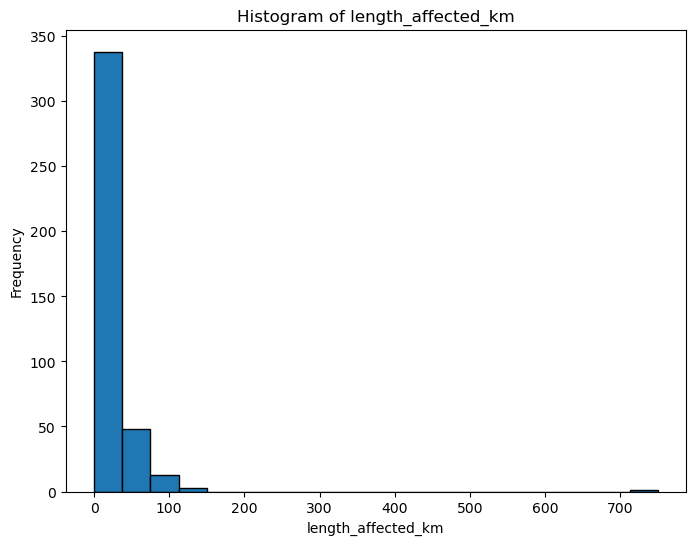

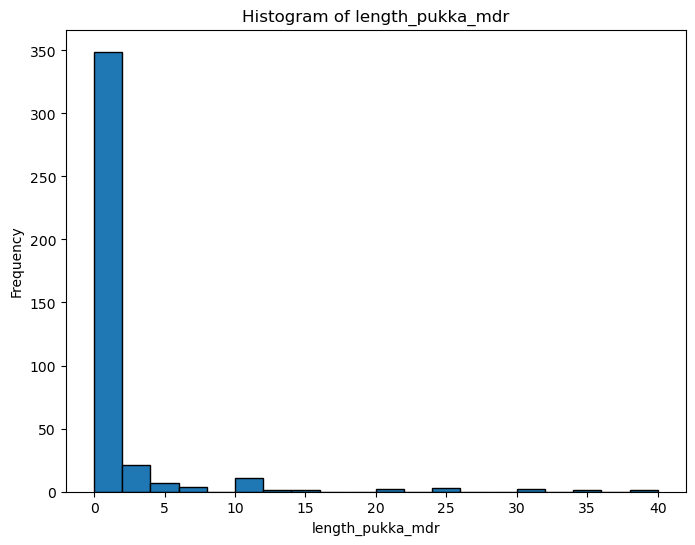

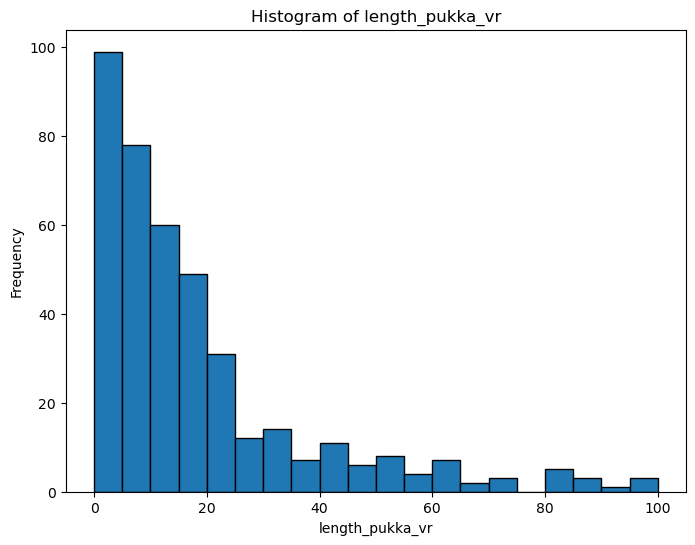

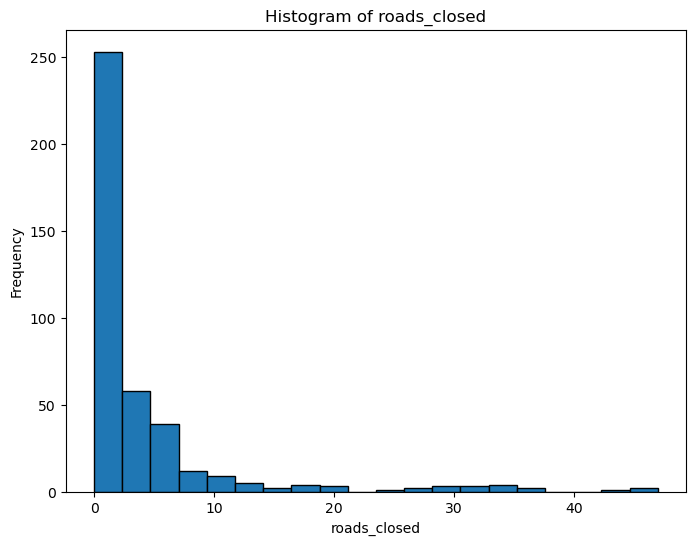

In [ ]:
import matplotlib.pyplot as plt

# Define the columns you want to plot (example selected numeric columns)
selected_columns = ['length_affected_km', 'length_pukka_mdr', 'length_pukka_vr', 'roads_closed']

# Loop through the selected columns and plot histogram for each
for col in selected_columns:
    plt.figure(figsize=(8, 6))
    plt.hist(pwd_mon23_kangra_gc[col].dropna(), bins=20, edgecolor='black')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
tagged_df = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\loss_master_geocoded.csv')
tagged_df.columns.to_list()

C:\Users\saura\AppData\Local\Temp\ipykernel_2972\2191294283.py:1: DtypeWarning: Columns (31,34,39,41,43,44,75,77,81,85,90,95,104,122,123,124,142,144) have mixed types. Specify dtype option on import or set low_memory=False.
  tagged_df = pd.read_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\loss_master_geocoded.csv')


['agriculture_loss_id',
 'disaster_id',
 'department_id',
 'district_id',
 'status',
 'croppedarea',
 'crop_lossless33',
 'cropsownarea',
 'crop_33_above',
 'kharif_id',
 'cmid',
 'totalAreadamaged',
 'ret_id',
 'block_id',
 'incidentdate',
 'district_name',
 'cattle_loss_id',
 'sub_district_id',
 'cattle_injured',
 'missingcattle',
 'MilchlostB',
 'MilchlostS',
 'DraughtlostC',
 'DraughtlostCalf',
 'MilchqB',
 'milchqS',
 'DraughtqC',
 'DraughtqCalf',
 'sub_district_name',
 'sub_districtCode',
 'education_loss_id',
 'other_details',
 'institute_type_id',
 'economic_loss',
 'block_name',
 'health_loss_id',
 'centre_type_id',
 'centres_lost',
 'blockid',
 'health_centerName',
 'amount',
 'Details',
 'education_loss_det_id',
 'school_name',
 'remark',
 'amountloss',
 'horticulture_loss_id',
 'crop_33_affected',
 'croptype',
 'mf1',
 'sf1',
 'of1',
 'tf1',
 'mf2',
 'sf2',
 'of2',
 'tf2',
 'cd',
 'pd',
 'cd2',
 'pd2',
 'Qloss',
 'Qltloss',
 'farmerso',
 'farmers',
 'areaunderfruits',
 'tot

In [ ]:
# Fill missing values for district_name using district_best and then district_alternative
tagged_df['filled_district'] = tagged_df['district_name'].fillna(tagged_df['district_best']).fillna(tagged_df['district_alternative'])

# Fill missing values for sub_district_name using sub_district_best and then sub_district_alternative
tagged_df['filled_tehsil'] = tagged_df['sub_district_name'].fillna(tagged_df['subdistrict_best']).fillna(tagged_df['subdistrict_alternative'])

# Copy the filled values into new columns and convert them to uppercase
tagged_df['DISTRICT_FINALISED'] = tagged_df['filled_district'].str.upper()
tagged_df['TEHSIL_FINALISED'] = tagged_df['filled_tehsil'].str.upper()

In [ ]:
tagged_df.columns.to_list()

['agriculture_loss_id',
 'disaster_id',
 'department_id',
 'district_id',
 'status',
 'croppedarea',
 'crop_lossless33',
 'cropsownarea',
 'crop_33_above',
 'kharif_id',
 'cmid',
 'totalAreadamaged',
 'ret_id',
 'block_id',
 'incidentdate',
 'district_name',
 'cattle_loss_id',
 'sub_district_id',
 'cattle_injured',
 'missingcattle',
 'MilchlostB',
 'MilchlostS',
 'DraughtlostC',
 'DraughtlostCalf',
 'MilchqB',
 'milchqS',
 'DraughtqC',
 'DraughtqCalf',
 'sub_district_name',
 'sub_districtCode',
 'education_loss_id',
 'other_details',
 'institute_type_id',
 'economic_loss',
 'block_name',
 'health_loss_id',
 'centre_type_id',
 'centres_lost',
 'blockid',
 'health_centerName',
 'amount',
 'Details',
 'education_loss_det_id',
 'school_name',
 'remark',
 'amountloss',
 'horticulture_loss_id',
 'crop_33_affected',
 'croptype',
 'mf1',
 'sf1',
 'of1',
 'tf1',
 'mf2',
 'sf2',
 'of2',
 'tf2',
 'cd',
 'pd',
 'cd2',
 'pd2',
 'Qloss',
 'Qltloss',
 'farmerso',
 'farmers',
 'areaunderfruits',
 'tot

In [ ]:
reduced_df = tagged_df[[#'agriculture_loss_id',
 'disaster_id',
 'department_id',
 'district_id',
 'status',
 'croppedarea',
 'crop_lossless33',
 'cropsownarea',
 'crop_33_above',
 'kharif_id',
 #'cmid',
 'totalAreadamaged',
 #'ret_id',
 #'block_id',
 'incidentdate',
 #'district_name',
 'cattle_loss_id',
 'sub_district_id',
 'cattle_injured',
 'missingcattle',
 'MilchlostB',
 'MilchlostS',
 'DraughtlostC',
 'DraughtlostCalf',
 'MilchqB',
 'milchqS',
 'DraughtqC',
 'DraughtqCalf',
 #'sub_district_name',
 #'sub_districtCode',
 #'education_loss_id',
 'other_details',
 'institute_type_id',
 'economic_loss',
 'block_name',
 #'health_loss_id',
 'centre_type_id',
 'centres_lost',
 #'blockid',
 'health_centerName',
 'amount',
 'Details',
 'education_loss_det_id',
 'school_name',
 #'remark',
 'amountloss',
 'horticulture_loss_id',
 'crop_33_affected',
 'croptype',
 'mf1',
 'sf1',
 'of1',
 'tf1',
 'mf2',
 'sf2',
 'of2',
 'tf2',
 'cd',
 'pd',
 'cd2',
 'pd2',
 'Qloss',
 'Qltloss',
 'farmerso',
 'farmers',
 'areaunderfruits',
 'totalareaall',
 'area33',
 'arearainfed',
 'areairrigated',
 'areaperennial',
 'iph_loss_id',
 #'division_id',
 #'circle_id',
 #'entryno',
 'division_name',
 #'CId',
 'circle',
 'human_loss_id',
 'person_dead',
 'person_major_injury',
 'person_minor_injury',
 'person_missing',
 #'municipal_loss_id',
 'Roadlength',
 'detailsremovalofdebris',
 'Electricpoles',
 'electricwires',
 'internalwatersupply',
 'streetlights',
 'nameofbuilding',
 'municipalname',
 'ULB',
 'type',
 'ulb_id',
 'ulb_name',
 'power_loss_id',
 'htline_damaged_km',
 'rate_km_htline',
 'ltline_damaged_km',
 'rate_km_ltline',
 'ltpoles_damaged',
 'rate_km_pole',
 'funds_required',
 'location',
 'totalht',
 'totallt',
 'totalpole',
 'drttotal',
 'drtdam',
 'drtloss',
 'pwd_loss_id',
 'length_affected_km',
 'roads_closed',
 'length_pukka_mdr',
 'length_pukka_vr',
 'length_kuccha_mdr',
 'length_kuccha_vr',
 'jcb_deployed_department',
 'jcb_deployed_hired',
 'dosers_deployed',
 'tipper_deployed',
 'roadopeningdate1',
 'roadopeningdate2',
 'roadopeningdate3',
 'roadopens1',
 'roadopens2',
 'roadopens3',
 'length_pukka_sh',
 'pwd_bridge',
 'pwd_culvert',
 'structure_loss_id',
 'structure_type_id',
 'structure_lost',
 'loss_type',
 'countno',
 #'Victum_Name',
 #'Victum_Address',
 'add_RelifAmount',
 #'entry_no',
 'structure_type',
 #'subdistrict_best',
 #'subdistrict_alternative',
 #'district_best',
 #'district_alternative',
 #'filled_district',
 #'filled_tehsil',
 'DISTRICT_FINALISED',
 'TEHSIL_FINALISED']]

In [ ]:
reduced_df = reduced_df.loc[reduced_df['status'].isin(['Active',''])]
#reduced_df = reduced_df.loc[reduced_df['status'].isin(['Active',''])]

In [ ]:
reduced_df.to_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\Dashboards\HP_losses_and_damages\HP_losses_and_damages.csv', index=False)

In [ ]:
final_geocoded_df.to_csv(r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\loss_master_geocoded.csv', index=False)


In [ ]:
import os
import re
import pandas as pd
import geopandas as gpd
from difflib import SequenceMatcher
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# write a script that takes entries from specific columns within a row and checks if they are present in any of the above list of columns. it then finds the closest match and creates a new column with the closest match - and also references which column it is most closely matched with.

### Function to identify columns common between dataframes

In [ ]:
import os
import glob

# Set the directory containing the CSV files (update this path as needed)
csv_dir = r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\HP\flood-data-ecosystem-Himachal-Pradesh\Sources\HPSDMA\data\losses-and-damages\Loss Data\\keys_identifiers'

# Get the list of CSV file paths in the directory
csv_files = glob.glob(os.path.join(csv_dir, "*.csv"))
print(csv_files)
# Dictionary to record for each column the list of CSV files (by basename) where it appears
column_files = {}

for file in csv_files:
    try:
        # Read only the header (to save time)
        df_header = pd.read_csv(file, nrows=0)
        for col in df_header.columns:
            column_files.setdefault(col, []).append(os.path.basename(file))
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Filter to get columns that are present in more than one CSV file
common_columns = {col: files for col, files in column_files.items() if len(files) > 1}

# Create a new DataFrame with the common columns and the list of CSV files they appear in
result_df = pd.DataFrame({
    'Column': list(common_columns.keys()),
    'Files': [", ".join(files) for files in common_columns.values()]
})

result_df

['D:\\CivicDataLab_IDS-DRR\\IDS-DRR_Github\\HP\\flood-data-ecosystem-Himachal-Pradesh\\Sources\\HPSDMA\\data\\losses-and-damages\\Loss Data\\\\keys_identifiers\\affected_area_id.csv', 'D:\\CivicDataLab_IDS-DRR\\IDS-DRR_Github\\HP\\flood-data-ecosystem-Himachal-Pradesh\\Sources\\HPSDMA\\data\\losses-and-damages\\Loss Data\\\\keys_identifiers\\agriculture_loss.csv', 'D:\\CivicDataLab_IDS-DRR\\IDS-DRR_Github\\HP\\flood-data-ecosystem-Himachal-Pradesh\\Sources\\HPSDMA\\data\\losses-and-damages\\Loss Data\\\\keys_identifiers\\agriculture_loss2.csv', 'D:\\CivicDataLab_IDS-DRR\\IDS-DRR_Github\\HP\\flood-data-ecosystem-Himachal-Pradesh\\Sources\\HPSDMA\\data\\losses-and-damages\\Loss Data\\\\keys_identifiers\\category_id.csv', 'D:\\CivicDataLab_IDS-DRR\\IDS-DRR_Github\\HP\\flood-data-ecosystem-Himachal-Pradesh\\Sources\\HPSDMA\\data\\losses-and-damages\\Loss Data\\\\keys_identifiers\\cattle_master.csv', 'D:\\CivicDataLab_IDS-DRR\\IDS-DRR_Github\\HP\\flood-data-ecosystem-Himachal-Pradesh\\Sourc

,Column,Files
0,disaster_id,"affected_area_id.csv, agriculture_loss.csv, ag..."
1,district_id,"affected_area_id.csv, agriculture_loss.csv, ag..."
2,sub_district_id,"affected_area_id.csv, agriculture_loss.csv, ag..."
3,status,"affected_area_id.csv, agriculture_loss.csv, ag..."
4,entry_by,"affected_area_id.csv, agriculture_loss.csv, ag..."
5,entry_date,"affected_area_id.csv, agriculture_loss.csv, ag..."
6,ip_addr,"affected_area_id.csv, agriculture_loss.csv, ag..."
7,agriculture_loss_id,"agriculture_loss.csv, agriculture_loss2.csv"
8,department_id,"agriculture_loss.csv, agriculture_loss2.csv, c..."
9,developmentId,"agriculture_loss.csv, agriculture_loss2.csv"


In [ ]:

def geocode_district(sdrf_df, HP_VILLAGES):
    """
    Performs initial geocoding at the district level.
    First, a fuzzy-match corrects the tender 'location' field against revenue circle names.
    Then, using multiple text fields (external reference, title/description, location), 
    candidate district assignments are made and a weightage logic finalizes the district.
    """
    # --- Fuzzy-match location to revenue circle names ---
    unique_rcs = HP_VILLAGES['revenue_ci'].dropna().unique()
    locations = []
    for idx, row in sdrf_df.iterrows():
        #loc_clean = str(row['TREASURY NAME']).lower().replace('Chariali','').replace('Kamrup,','').replace('dist','')
        loc_clean = re.sub(r'[^a-zA-Z\n\.]', ' ', loc_clean)
        scores = [SequenceMatcher(None, loc_clean, rc.lower().strip()).ratio() for rc in unique_rcs]
        if scores and max(scores) > 0.8:
            best_match = unique_rcs[scores.index(max(scores))]
            locations.append(best_match)
        else:
            locations.append(row['TREASURY NAME'])
    sdrf_df['TREASURY NAME'] = locations

    # --- Prepare lists for matching ---
    assam_districts = list(set(HP_VILLAGES['district_2'].dropna()) - set(['KAMRUP','KAMRUP METRO']))
    assam_revenue_circles = list(set(HP_VILLAGES['revenue_ci'].dropna()))
    assam_sub_districts = list(set(HP_VILLAGES['sdtname_2'].dropna()))
    
    # Build dictionaries for revenue circles and sub-districts (used later)
    assam_revenue_circles_dict = (HP_VILLAGES[['revenue_ci','district_2']]
                                  .dropna().drop_duplicates().drop_duplicates(['revenue_ci'], keep='first')
                                  .set_index('revenue_ci').to_dict(orient='index'))
    assam_subdist_dict = (HP_VILLAGES[['sdtname_2','district_2']]
                          .dropna().drop_duplicates().drop_duplicates(['sdtname_2'], keep='first')
                          .set_index('sdtname_2').to_dict(orient='index'))
    
    # --- Assign district candidates from multiple sources ---
    sdrf_df = assign_district_candidates(sdrf_df, assam_districts, assam_revenue_circles,
                                         assam_sub_districts, assam_revenue_circles_dict,
                                         assam_subdist_dict, three_letter_distirct_identifiers_dict)
    return sdrf_df


def assign_district_candidates(sdrf_df, assam_districts, assam_revenue_circles, assam_sub_districts,
                               assam_revenue_circles_dict, assam_subdist_dict, three_letter_dict):
    """
    For each tender, this function generates candidate district assignments from:
      - The tender external reference
      - The tender title and Aim, objectives and benefit expected from the scheme/project
      - The tender location
    Then it uses a simple weightage logic to finalize the district.
    """
    # Candidate 1: Based on external reference
    sdrf_df['expense_district_externalReference'] = None
    for idx, row in sdrf_df.iterrows():
        ref = str(row['DDO Code'])
        district_identifier = ref.split('/')[0].lower()
        if 'rgr' in district_identifier:
            district_identifier = district_identifier.split('rgr')[0].strip()[:-1]
        if district_identifier in three_letter_dict:
            sdrf_df.loc[idx, 'expense_district_externalReference'] = three_letter_dict[district_identifier]

    # Candidate 2: Based on title and Aim, objectives and benefit expected from the scheme/project
    sdrf_df['tender_district_title_description'] = None
    for idx, row in sdrf_df.iterrows():
        expense_slug = f"{row['Name of the Scheme']} {row['Aim, objectives and benefit expected from the scheme/project']}"
        expense_slug = re.sub(r'[^a-zA-Z0-9 \n\.]', ' ', expense_slug)
        # Try direct district match
        for district in assam_districts:
            if re.search(r'\b' + re.escape(district.lower().strip()) + r'\b', expense_slug.lower()):
                sdrf_df.loc[idx, 'tender_district_title_description'] = district
                break
        # Fallback to matching revenue circles
        if sdrf_df.loc[idx, 'tender_district_title_description'] is None:
            for rc in assam_revenue_circles:
                if re.search(r'\b' + re.escape(rc.lower().strip()) + r'\b', expense_slug.lower()):
                    if rc in assam_revenue_circles_dict:
                        sdrf_df.loc[idx, 'tender_district_title_description'] = assam_revenue_circles_dict[rc]['district_2']
                    else:
                        # Optionally, assign the revenue circle itself or leave as NA
                        sdrf_df.loc[idx, 'tender_district_title_description'] = rc
                    break

        # Fallback to matching sub-districts
        if sdrf_df.loc[idx, 'tender_district_title_description'] is None:
            for sd in assam_sub_districts:
                if re.search(r'\b' + re.escape(sd.lower()) + r'\b', expense_slug.lower()):
                    sdrf_df.loc[idx, 'tender_district_title_description'] = assam_subdist_dict[sd]['district_2']
                    break

    # Candidate 3: Based on location
    sdrf_df['tender_district_location'] = None
    for idx, row in sdrf_df.iterrows():
        expense_slug = str(row['TREASURY NAME'])
        expense_slug = re.sub(r'[^a-zA-Z0-9 \n\.]', ' ', expense_slug)
        for district in assam_districts:
            if re.search(r'\b' + re.escape(district.lower().strip()) + r'\b', expense_slug.lower()):
                sdrf_df.loc[idx, 'tender_district_location'] = district
                break
        if sdrf_df.loc[idx, 'tender_district_location'] is None:
            for rc in assam_revenue_circles:
                if re.search(r'\b' + re.escape(rc.lower().strip()) + r'\b', expense_slug.lower()):
                    if rc in assam_revenue_circles_dict:
                        sdrf_df.loc[idx, 'tender_district_title_description'] = assam_revenue_circles_dict[rc]['district_2']
                    else:
                        # Optionally, assign the revenue circle itself or leave as NA
                        sdrf_df.loc[idx, 'tender_district_title_description'] = rc
                    break

        if sdrf_df.loc[idx, 'tender_district_location'] is None:
            for sd in assam_sub_districts:
                if re.search(r'\b' + re.escape(sd.lower()) + r'\b', expense_slug.lower()):
                    sdrf_df.loc[idx, 'tender_district_location'] = assam_subdist_dict[sd]['district_2']
                    break

    # Finalize district using weightage logic
    sdrf_df['expense_district_externalReference'].fillna('NA', inplace=True)
    sdrf_df['tender_district_title_description'].fillna('NA', inplace=True)
    sdrf_df['tender_district_location'].fillna('NA', inplace=True)
    sdrf_df['DISTRICT_FINALISED'] = ''
    for idx, row in sdrf_df.iterrows():
        districts = {row['expense_district_externalReference'],
                     row['tender_district_title_description'],
                     row['tender_district_location']}
        districts = {d for d in districts if d != 'NA'}
        if len(districts) == 1:
            sdrf_df.loc[idx, 'DISTRICT_FINALISED'] = list(districts)[0]
        elif len(districts) == 0:
            sdrf_df.loc[idx, 'DISTRICT_FINALISED'] = 'NA'
        else:
            sdrf_df.loc[idx, 'DISTRICT_FINALISED'] = 'CONFLICT'
    return sdrf_df


def geocode_details(tender_df, HP_VILLAGES, RC_HQs):
    """
    For each district (FOCUS_DISTRICT), this function builds district-specific dictionaries 
    (villages, blocks, revenue circles, subdistricts) from the master villages data.
    Then it matches tender text (a combination of tender fields) against these units to assign
    detailed geocoding (village, block, subdistrict, revenue circle). Finally, it uses the revenue
    circle HQ information to finalize the revenue circle assignment.
    """
    MASTER_DF_list = []
    
    # Process each district from the master village data
    for FOCUS_DISTRICT in tqdm(HP_VILLAGES['district_2'].unique(), desc="Detail Geocoding"):
        district_df = HP_VILLAGES[HP_VILLAGES['district_2'] == FOCUS_DISTRICT]
        FOCUSDIST_village_dict = {}
        FOCUSDIST_block_dict = {}
        FOCUSDIST_subdistrict_dict = {}
        FOCUSDIST_revcircle_dict = {}
        
        for idx, row in district_df.iterrows():
            # Clean village name and correct if needed
            if row["VILNAM_SOI"]:
                village_clean = re.sub(r'[^a-zA-Z]', "", row["VILNAM_SOI"])
                if village_clean in VILLAGE_CORRECTION_DICT:
                    village_clean = VILLAGE_CORRECTION_DICT[village_clean]
                FOCUSDIST_village_dict[village_clean] = {
                    "village_id": row["OBJECTID"],
                    "block_name": row["block_name"],
                    "subdistrict": row["sdtname_2"],
                    "revenuecircle": row["revenue_ci"],
                    "district_2": row["district_2"]
                }
            FOCUSDIST_block_dict[row["block_name"]] = {
                "subdistrict": row["sdtname_2"],
                "revenuecircle": row["revenue_ci"],
                "district_2": row["district_2"]
            }
            FOCUSDIST_subdistrict_dict[row["sdtname_2"]] = {"district_2": row["district_2"]}
            FOCUSDIST_revcircle_dict[row["revenue_ci"]] = {"district_2": row["district_2"]}
        
        # Remove any unwanted keys if present
        for key in ['RIVER', 'NO', 'TOWN']:
            FOCUSDIST_village_dict.pop(key, None)
        
        FOCUSDIST_villages = list(FOCUSDIST_village_dict.keys())
        FOCUSDIST_blocks = list(FOCUSDIST_block_dict.keys())
        FOCUSDIST_subdistricts = list(FOCUSDIST_subdistrict_dict.keys())
        FOCUSDIST_revcircles = list(FOCUSDIST_revcircle_dict.keys())
        
        # Subset tenders geocoded to this district
        tender_subset = tender_df[tender_df["DISTRICT_FINALISED"] == FOCUS_DISTRICT].copy()
        
        # Define a regex pattern to remove specific substrings
        substrings_to_remove = ["(pt)", "\n"]
        pattern = "|".join(map(re.escape, substrings_to_remove))
        
        # Process each tender in the focused district
        for idx, row in tender_subset.iterrows():
            expense_slug = f"{row['Name of the Scheme']} {row['Aim, objectives and benefit expected from the scheme/project']}"
            expense_slug = re.sub(r'[^a-zA-Z0-9 \n\.]', ' ', expense_slug)
            
            tender_villages = []
            tender_village_id = ""
            tender_block = ""
            tender_revenueci = ""
            tender_subdistrict = ""
            tender_revenueci_location = ""
            
            # Match village names
            for village in FOCUSDIST_villages:
                if not re.search(r'[a-zA-Z]', village):
                    continue 
                village_search = re.sub(pattern, " ", village.lower())
                if re.search(r'\b' + re.escape(village_search.strip()) + r'\b', expense_slug.lower()):
                    tender_villages.append(village)
                    tender_village_id = FOCUSDIST_village_dict[village]['village_id']
                    tender_block = FOCUSDIST_village_dict[village]['block_name']
                    tender_revenueci = FOCUSDIST_village_dict[village]['revenuecircle']
                    tender_subdistrict = FOCUSDIST_village_dict[village]['subdistrict']
            
            # If no village found, try matching block names
            if not tender_block:
                for block in FOCUSDIST_blocks:
                    block_search = re.sub(pattern, " ", block.lower())
                    if re.search(r'\b' + re.escape(block_search.strip()) + r'\b', expense_slug.lower()):
                        tender_block = block
                        tender_revenueci = FOCUSDIST_block_dict[block]['revenuecircle']
                        tender_subdistrict = FOCUSDIST_block_dict[block]['subdistrict']
                        break
            
            # Try matching revenue circle from the tender slug
            for revenue_circle in FOCUSDIST_revcircles:
                revenue_circle_search = re.sub(pattern, " ", revenue_circle.lower())
                if re.search(r'\b' + re.escape(revenue_circle_search.strip()) + r'\b', expense_slug.lower()):
                    tender_revenueci = revenue_circle
                    break
            
            # Try matching revenue circle from the tender 'location' field
            for revenue_circle in FOCUSDIST_revcircles:
                revenue_circle_search = re.sub(pattern, " ", revenue_circle.lower())
                if re.search(r'\b' + re.escape(revenue_circle_search.strip()) + r'\b', str(row['TREASURY NAME']).lower()):
                    tender_revenueci_location = revenue_circle
                    break
            
            # Try matching subdistrict from the tender slug
            for subdistrict in FOCUSDIST_subdistricts:
                subdistrict_search = re.sub(pattern, " ", subdistrict.lower())
                if re.search(r'\b' + re.escape(subdistrict_search.strip()) + r'\b', expense_slug.lower()):
                    tender_subdistrict = subdistrict
                    break
            
            # Save matched details into the dataframe
            tender_subset.loc[idx, 'tender_villages'] = ','.join(tender_villages)
            tender_subset.loc[idx, 'tender_block'] = tender_block
            tender_subset.loc[idx, 'tender_subdistrict'] = tender_subdistrict
            tender_subset.loc[idx, 'tender_revenueci'] = tender_revenueci
            tender_subset.loc[idx, 'tender_revenueci_location'] = tender_revenueci_location
        
        MASTER_DF_list.append(tender_subset)
    
    # Append tenders that did not get a clear district assignment
    MASTER_DF_list.append(tender_df[tender_df["DISTRICT_FINALISED"] == 'NA'])
    MASTER_DF_list.append(tender_df[tender_df["DISTRICT_FINALISED"] == 'CONFLICT'])
    
    MASTER_DF = pd.concat(MASTER_DF_list, ignore_index=True)
    
    # Finalize revenue circle using HQ flag from revenue circle geo-data
    MASTER_DF['HQ_flag'] = False
    MASTER_DF['REVENUE_CIRCLE_FINALISED'] = ''
    for idx, row in MASTER_DF.iterrows():
        if row.get('tender_revenueci_location', '') in RC_HQs:
            MASTER_DF.loc[idx, 'HQ_flag'] = True
        if row.get('tender_revenueci_location', ''):
            MASTER_DF.loc[idx, 'REVENUE_CIRCLE_FINALISED'] = row['tender_revenueci_location']
        else:
            MASTER_DF.loc[idx, 'REVENUE_CIRCLE_FINALISED'] = row.get('tender_revenueci', '')
        if row.get('tender_revenueci_location', '') == row.get('tender_revenueci', ''):
            MASTER_DF.loc[idx, 'REVENUE_CIRCLE_FINALISED'] = row['tender_revenueci']
    
    return MASTER_DF


def main():
    """
    Main function to run the consolidated geocoding workflow.
    It loads data, applies district geocoding, then detailed geocoding,
    and finally writes the geotagged output to CSV.
    """
    # Load raw data
    sdrf_df, HP_VILLAGES, ASSAM_RCS = load_data()
    
    # Perform district-level geocoding
    sdrf_df = geocode_district(sdrf_df, HP_VILLAGES)
    
    # (Optional) Write intermediate district-geotagged data
    district_out_path = r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\IDS-DRR-Assam\Sources\SDRF\data\flood_expenses_RCgeotagged.csv'
    sdrf_df.to_csv(district_out_path, index=False)
    
    # Get list of Revenue Circle HQs from the revenue circle geodata
    RC_HQs = list(ASSAM_RCS[ASSAM_RCS['HQ'] == 'y']['revenue_ci'])
    
    # Perform detailed geocoding (villages, blocks, etc.) based on finalized district tags
    MASTER_DF = geocode_details(sdrf_df, HP_VILLAGES, RC_HQs)
    
    # Write final geocoded output
    final_out_path = r'D:\CivicDataLab_IDS-DRR\IDS-DRR_Github\IDS-DRR-Assam\Sources\SDRF\data\flood_expenses_RCgeotagged.csv'
    MASTER_DF.to_csv(final_out_path, index=False)
    
    # Print summary statistics
    total = sdrf_df.shape[0]
    na_count = sdrf_df[sdrf_df['DISTRICT_FINALISED'] == 'NA'].shape[0]
    conflict_count = sdrf_df[sdrf_df['DISTRICT_FINALISED'] == 'CONFLICT'].shape[0]
    print('Total number of flood related tenders:', total)
    print('Number of tenders whose district could not be geo-tagged:', na_count)
    print('Number of tenders with district identification conflicts:', conflict_count)


if __name__ == '__main__':
    main()